# Figure 1: Adhesome genes/loci are close in HiC

In [1]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures4/correlation_clustering.py'>

In [2]:
# Specify all directories
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

### Load gene data

In [4]:
# Active/inactive loci
all_active_loci = pickle.load(open(saving_dir+'all_active_loci.pkl', 'rb'))
all_inactive_loci = pickle.load(open(saving_dir+'all_inactive_loci.pkl', 'rb'))
# Active/inactive genes
active_genes = pickle.load(open(saving_dir+'active_genes.pkl','rb'))
inactive_genes = pickle.load(open(saving_dir+'inactive_genes.pkl','rb'))

In [5]:
# Adhesome genes
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_loci.pkl', 'rb'))
inactive_adhesome_loci = pickle.load(open(saving_dir+'inactive_adhesome_loci.pkl', 'rb'))
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl','rb'))
inactive_adhesome_genes = pickle.load(open(saving_dir+'inactive_adhesome_genes.pkl','rb'))
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl','rb'))
all_adhesome_genes = np.array(list(set(active_adhesome_genes).union(set(inactive_adhesome_genes))))

In [6]:
# TCR genes
tcr_chr_loci = pickle.load(open(saving_dir+'tcr_chr_loci.pkl', 'rb'))
tcr_genes = pickle.load(open(saving_dir+'tcr_genes.pkl', 'rb'))
tcr_loci = pickle.load(open(saving_dir+'tcr_loci.pkl', 'rb'))
active_tcr_genes = pickle.load(open(saving_dir+'active_tcr_genes.pkl', 'rb'))
active_tcr_loci = pickle.load(open(saving_dir+'active_tcr_loci.pkl', 'rb'))
inactive_tcr_genes = pickle.load(open(saving_dir+'inactive_tcr_genes.pkl', 'rb'))
inactive_tcr_loci = pickle.load(open(saving_dir+'inactive_tcr_loci.pkl', 'rb'))

### Active/inactive adhesome and TCR loci per chromosome

Number of active adhesome loci = 281
Number of inactive adhesome loci = 16


<Figure size 432x288 with 0 Axes>

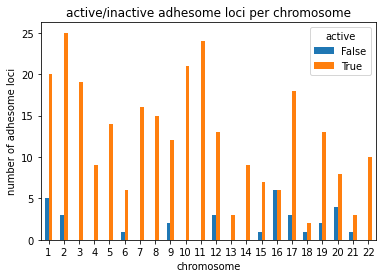

In [7]:
# Basic statistics
print('Number of active adhesome loci = '+str(len(active_adhesome_loci)))
print('Number of inactive adhesome loci = '+str(len(inactive_adhesome_loci)))
# Plot number of active/inactive adhesome loci for all chromosomes
df_bar = adhesome_chr_loci.groupby(['chrom_int'])
df_bar1 = df_bar['active'].value_counts().unstack()
plt.figure()
df_bar1.plot(kind='bar', title='active/inactive adhesome loci per chromosome')
plt.xticks(rotation='horizontal')
plt.xlabel('chromosome')
plt.ylabel('number of adhesome loci')
plt.show()

Number of active TCR loci = 103
Number of inactive TCR loci = 10


<Figure size 432x288 with 0 Axes>

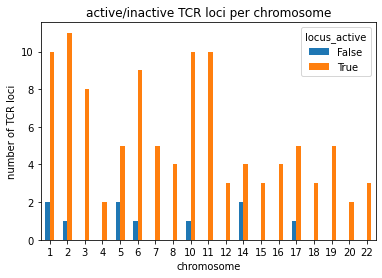

In [8]:
# Basic statistics
print('Number of active TCR loci = '+str(len(active_tcr_loci)))
print('Number of inactive TCR loci = '+str(len(inactive_tcr_loci)))
# Plot number of active/inactive tcr loci for all chromosomes
df_bar = tcr_chr_loci.groupby(['chrom_int'])
df_bar1 = df_bar['locus_active'].value_counts().unstack()
plt.figure()
df_bar1.plot(kind='bar', title='active/inactive TCR loci per chromosome')
plt.xticks(rotation='horizontal')
plt.xlabel('chromosome')
plt.ylabel('number of TCR loci')
plt.show()

### Select adhesome genes and non-adhesome TCR genes

In [9]:
# Select genes
both_genes = np.array(list(set(tcr_genes).intersection(set(all_adhesome_genes))))
selected_tcr_loci =  tcr_chr_loci[(~tcr_chr_loci['gene'].isin(both_genes))]['locus_id'].unique()
selected_adhesome_loci = adhesome_chr_loci['locus_id'].unique()

### Compare to random loci

In [10]:
# Import list of all blacklisted loci
blacklist_list = pickle.load(open(dir_processed_hic+'blacklist_list.pkl', 'rb'))

In [11]:
# Create a dictionary of all non-blacklisted non-adhesome and non-TCR for each chromosome
all_loci = list(set(all_active_loci).union(set(all_inactive_loci)))
all_loci_without_selected = list(set(all_loci)-set(selected_adhesome_loci)-set(selected_tcr_loci))
all_loci_without_selected = list(set(all_loci_without_selected)-set(blacklist_list))
loci_pool = {chrom: [locus for locus in all_loci_without_selected if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}

In [12]:
# Number of adhesome and TCR genes per chrom
number_adhesome_per_chrom = {chrom: len([locus for locus in selected_adhesome_loci 
                                                if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}
number_tcr_per_chrom = {chrom: len([locus for locus in selected_tcr_loci 
                                                if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}

In [13]:
# Random non-blacklisted non-adhesome and non-TCR active loci
random.seed(13)
random_non_tcr_loci = list(itertools.chain.from_iterable(
    [random.sample(loci_pool[chrom],number_tcr_per_chrom[chrom]) 
     for chrom in np.arange(1,22+1,1)]))
pickle.dump(random_non_tcr_loci ,open(saving_dir+'random_non_tcr_loci.pkl', 'wb'))

In [14]:
# Create list out of all adhesome and random groups of loci
random_non_tcr_loci = np.array(pickle.load(open(saving_dir+'random_non_tcr_loci.pkl', 'rb')))
# Group all loci list by chromosome
selected_tcr_loci = selected_tcr_loci[np.argsort([int(locus.split('_')[1]) 
                                              for locus in selected_tcr_loci])]
selected_adhesome_loci = selected_adhesome_loci[np.argsort([int(locus.split('_')[1]) 
                                                        for locus in selected_adhesome_loci])]
random_non_tcr_loci = random_non_tcr_loci[np.argsort([int(locus.split('_')[1]) 
                                                                    for locus in random_non_tcr_loci])]
# Create combined list
loci_list = list(itertools.chain.from_iterable([selected_tcr_loci,
                                                selected_adhesome_loci,
                                                random_non_tcr_loci]))
loci_list = np.unique(loci_list)

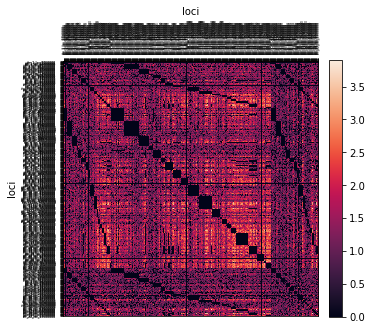

In [18]:
# Load contacts_df_tcr
contacts_df_tcr = pickle.load(open(saving_dir+'contacts_df_tcr.pkl', 'rb'))
# Plot data frame as heatmap
selected_loci_list = list(itertools.chain.from_iterable([selected_tcr_loci,
                                                       selected_adhesome_loci, 
                                                       random_non_tcr_loci]))
lu.plot_heatmap(contacts_df_tcr.loc[selected_loci_list,selected_loci_list],
                selected_loci_list, selected_loci_list, 'loci', 'loci', 
                5, contacts_df_tcr.loc[selected_loci_list,selected_loci_list].max().max(), add_patches = [])

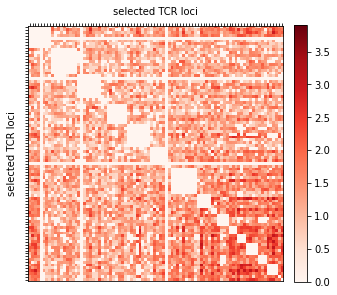

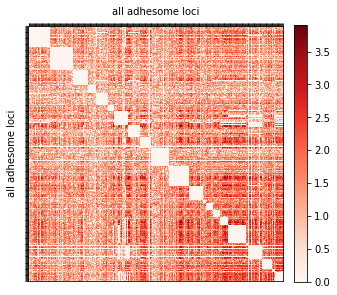

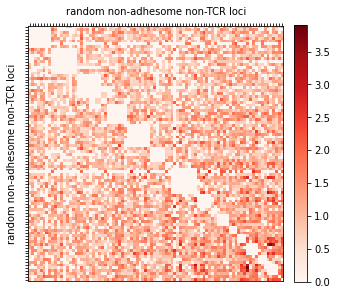

In [19]:
# Load contacts_df1
contacts_df_tcr = pickle.load(open(saving_dir+'contacts_df_tcr.pkl', 'rb'))
# Plot heatmaps
lu.plot_heatmap(contacts_df_tcr.loc[selected_tcr_loci,selected_tcr_loci],
                ['' for _ in selected_tcr_loci], ['' for _ in selected_tcr_loci], 
                'selected TCR loci', 'selected TCR loci', 
                size=5, fontsize=5,
                vmax=contacts_df_tcr.loc[selected_loci_list,selected_loci_list].max().max(), add_patches = [],
                cmap='Reds')
lu.plot_heatmap(contacts_df_tcr.loc[selected_adhesome_loci,selected_adhesome_loci],
                ['' for _ in selected_adhesome_loci], ['' for _ in selected_adhesome_loci], 
                'all adhesome loci', 'all adhesome loci', 
                size=5, fontsize=5,
                vmax=contacts_df_tcr.loc[selected_loci_list,selected_loci_list].max().max(), add_patches = [],
                cmap='Reds')
lu.plot_heatmap(contacts_df_tcr.loc[random_non_tcr_loci,random_non_tcr_loci],
                ['' for _ in random_non_tcr_loci], ['' for _ in random_non_tcr_loci], 
                'random non-adhesome non-TCR loci', 'random non-adhesome non-TCR loci', 
                size=5, fontsize=5,
                vmax=contacts_df_tcr.loc[selected_loci_list,selected_loci_list].max().max(), add_patches = [],
                cmap='Reds')

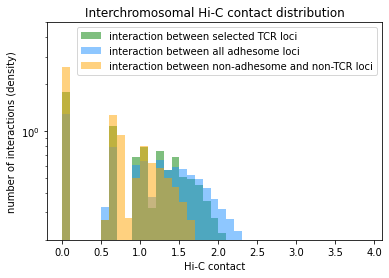

Wilcoxon Rank-Sums test (blue vs green):
RanksumsResult(statistic=13.402061775031603, pvalue=5.880648108143551e-41)
Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=129.93818767376348, pvalue=0.0)
Wilcoxon Rank-Sums test (green vs orange):
RanksumsResult(statistic=25.02188348363294, pvalue=3.5334802448629e-138)


In [25]:
# Histogram of average Hi-C contacts in three active cases

# Group of active TCR loci with itself (remove 0 values)
indices = np.triu_indices(len(contacts_df_tcr.loc[selected_tcr_loci,selected_tcr_loci]))
num_zeros_intraX = sum([int(number_tcr_per_chrom[chrom]*(number_tcr_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
selected_tcr_hic_with_itself = sorted(contacts_df_tcr.loc[selected_tcr_loci,
                                                             selected_tcr_loci].values[indices])[num_zeros_intraX:]

# Group of active adhesome loci with itself (remove 0 values)
indices = np.triu_indices(len(contacts_df_tcr.loc[selected_adhesome_loci,selected_adhesome_loci]))
num_zeros_intraX = sum([int(number_adhesome_per_chrom[chrom]*(number_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
selected_adhesome_hic_with_itself = sorted(contacts_df_tcr.loc[selected_adhesome_loci,
                                                             selected_adhesome_loci].values[indices])[num_zeros_intraX:]

# Group of all non-adhesome non-TCR loci with itself
nontcr_contacts_ls = pickle.load(open(saving_dir+'nontcr_contacts_ls.pkl', 'rb'))
all_nontcr_hic_with_itself = nontcr_contacts_ls

# Histogram
plt.figure()
plt.hist(selected_tcr_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=True, 
         color='green', label='interaction between selected TCR loci')
plt.hist(selected_adhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=True, 
         color='dodgerblue', label='interaction between all adhesome loci')
plt.hist(all_nontcr_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=True, 
         color='orange', label='interaction between non-adhesome and non-TCR loci')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions (density)')
plt.title('Interchromosomal Hi-C contact distribution')
plt.ylim(0.2,5)
plt.yscale('log')
plt.legend(loc='upper right') #, bbox_to_anchor=(1,0.5)
plt.show()
# Tests

print('Wilcoxon Rank-Sums test (blue vs green):')
print(ss.ranksums(selected_adhesome_hic_with_itself,
                  selected_tcr_hic_with_itself))
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(selected_adhesome_hic_with_itself,
                  all_nontcr_hic_with_itself))
print('Wilcoxon Rank-Sums test (green vs orange):')
print(ss.ranksums(selected_tcr_hic_with_itself,
                  all_nontcr_hic_with_itself))

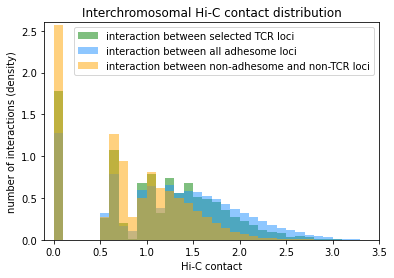

Wilcoxon Rank-Sums test (blue vs green):
RanksumsResult(statistic=13.402061775031603, pvalue=5.880648108143551e-41)
Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=129.93818767376348, pvalue=0.0)
Wilcoxon Rank-Sums test (green vs orange):
RanksumsResult(statistic=25.02188348363294, pvalue=3.5334802448629e-138)


In [34]:
# Histogram of average Hi-C contacts in three active cases

# Group of active TCR loci with itself (remove 0 values)
indices = np.triu_indices(len(contacts_df_tcr.loc[selected_tcr_loci,selected_tcr_loci]))
num_zeros_intraX = sum([int(number_tcr_per_chrom[chrom]*(number_tcr_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
selected_tcr_hic_with_itself = sorted(contacts_df_tcr.loc[selected_tcr_loci,
                                                             selected_tcr_loci].values[indices])[num_zeros_intraX:]

# Group of active adhesome loci with itself (remove 0 values)
indices = np.triu_indices(len(contacts_df_tcr.loc[selected_adhesome_loci,selected_adhesome_loci]))
num_zeros_intraX = sum([int(number_adhesome_per_chrom[chrom]*(number_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
selected_adhesome_hic_with_itself = sorted(contacts_df_tcr.loc[selected_adhesome_loci,
                                                             selected_adhesome_loci].values[indices])[num_zeros_intraX:]

# Group of all non-adhesome non-TCR loci with itself
#nontcr_contacts_ls = pickle.load(open(saving_dir+'nontcr_contacts_ls.pkl', 'rb'))
all_nontcr_hic_with_itself = nontcr_contacts_ls

# Histogram
plt.figure()
plt.hist(selected_tcr_hic_with_itself, 
         bins=np.arange(0,7.6,0.1), alpha=0.5, density=True, 
         color='green', label='interaction between selected TCR loci')
plt.hist(selected_adhesome_hic_with_itself, 
         bins=np.arange(0,7.6,0.1), alpha=0.5, density=True, 
         color='dodgerblue', label='interaction between all adhesome loci')
plt.hist(all_nontcr_hic_with_itself, 
         bins=np.arange(0,7.6,0.1), alpha=0.5, density=True, 
         color='orange', label='interaction between non-adhesome and non-TCR loci')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions (density)')
plt.title('Interchromosomal Hi-C contact distribution')
plt.ylim(0,2.6)
plt.xlim(-0.1,3.5)
plt.legend(loc='upper right') #, bbox_to_anchor=(1,0.5)
plt.show()
# Tests

print('Wilcoxon Rank-Sums test (blue vs green):')
print(ss.ranksums(selected_adhesome_hic_with_itself,
                  selected_tcr_hic_with_itself))
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(selected_adhesome_hic_with_itself,
                  all_nontcr_hic_with_itself))
print('Wilcoxon Rank-Sums test (green vs orange):')
print(ss.ranksums(selected_tcr_hic_with_itself,
                  all_nontcr_hic_with_itself))

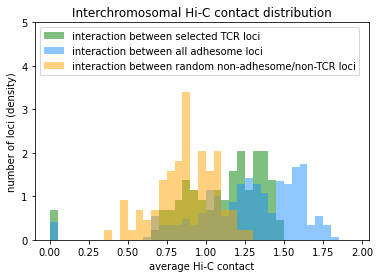

Wilcoxon Rank-Sums test (blue vs green):
RanksumsResult(statistic=4.984178758972021, pvalue=6.222553234342722e-07)
Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=10.34135295242291, pvalue=4.580248367680506e-25)
Wilcoxon Rank-Sums test (green vs orange):
RanksumsResult(statistic=6.314162182569957, pvalue=2.7162896608739143e-10)


In [35]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome loci with itself (remove 0 values)
selected_adhesome_hic_with_itself = contacts_df_tcr.loc[selected_adhesome_loci,
                                                        selected_adhesome_loci].sum(axis=1).values
selected_adhesome_hic_with_itself = selected_adhesome_hic_with_itself/(len(selected_adhesome_loci)-np.array([number_adhesome_per_chrom[int(l.split('_')[1])] 
                                                                                                       for l in selected_adhesome_loci]))

# Group of active TCR loci with itself (remove 0 values)
selected_tcr_hic_with_itself = contacts_df_tcr.loc[selected_tcr_loci,
                                                   selected_tcr_loci].sum(axis=1).values
selected_tcr_hic_with_itself = selected_tcr_hic_with_itself/(len(selected_tcr_loci)-np.array([number_tcr_per_chrom[int(l.split('_')[1])] 
                                                                                                       for l in selected_tcr_loci]))

# Group of random active non-adhesome loci with itself (remove 0 values)
random_hic_with_itself = contacts_df_tcr.loc[random_non_tcr_loci,
                                             random_non_tcr_loci].sum(axis=1).values
random_hic_with_itself = random_hic_with_itself/(len(random_non_tcr_loci)-np.array([number_tcr_per_chrom[int(l.split('_')[1])] 
                                                                                                       for l in random_non_tcr_loci]))

# Histogram
plt.figure()
plt.hist(selected_tcr_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=True, 
         color='green', label='interaction between selected TCR loci')
plt.hist(selected_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=True, 
         color='dodgerblue', label='interaction between all adhesome loci')
plt.hist(random_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=True, 
         color='orange', label='interaction between random non-adhesome/non-TCR loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci (density)')
plt.title('Interchromosomal Hi-C contact distribution')
plt.ylim(0,5)
plt.legend(loc='upper left') #, bbox_to_anchor=(1,0.5)
plt.show()

print('Wilcoxon Rank-Sums test (blue vs green):')
print(ss.ranksums(selected_adhesome_hic_with_itself,
                  selected_tcr_hic_with_itself))
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(selected_adhesome_hic_with_itself,
                  random_hic_with_itself))
print('Wilcoxon Rank-Sums test (green vs orange):')
print(ss.ranksums(selected_tcr_hic_with_itself,
                  random_hic_with_itself))